# Exercise 6

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [11]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for i, (inputs, labels) in enumerate(train_loader):
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()

        # TODO: run the network
        outputs = model(inputs)

        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(outputs, labels)

        # TODO: do backpropagation
        loss.backward()

        # TODO: optimize
        optimizer.step()

        # TODO: print current loss for every nth ("log_interval"th) iteration
        if i % log_interval == 0:
            print("Loss for epoch {} in iteration {}: {}".format(epoch, i, loss))

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [3]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [4]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)
       
    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = torch.flatten(x, 1)
        
        # TODO: run network layers
        x = self.fc1(x)
        x = torch.sigmoid(x)
        
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        x = self.fc3(x)
        x = torch.sigmoid(x)
        
        x = self.fc4(x)
        x = torch.sigmoid(x)
        
        x = self.fc5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        return output

In [5]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = torch.flatten(x, 1)
        
        # TODO: run network layers
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = F.relu(x)
        
        x = self.fc4(x)
        x = F.relu(x)
        
        x = self.fc5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        return output

In [6]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)
        self.bn1 = nn.BatchNorm1d(784)
        self.bn2 = nn.BatchNorm1d(100)
        
    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = torch.flatten(x, 1)
        
        # TODO: run network layers
        x = self.bn1(x)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.bn2(x)
        x = self.fc3(x)
        x = F.relu(x)
        
        x = self.fc4(x)
        x = F.relu(x)
        
        x = self.fc5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [7]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3, 2)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = torch.flatten(x, 1)
        
        # TODO: run fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [8]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3, 2)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.bn1 = nn.BatchNorm2d(1)
        self.bn2 = nn.BatchNorm1d(9216)
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.bn1(x)
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = torch.flatten(x, 1)
        
        # TODO: run fully connected layers
        x = self.bn2(x)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [9]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.bn1 = nn.BatchNorm2d(1)
        self.bn2 = nn.BatchNorm1d(9216)
        self.pool = nn.MaxPool2d((2, 2))
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.bn1(x)
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = torch.flatten(x, 1)
        
        # TODO: run fully connected layers
        x = self.bn2(x)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

Loss for epoch 1 in iteration 0: 2.316532850265503
Loss for epoch 1 in iteration 100: 0.4512927234172821
Loss for epoch 1 in iteration 200: 0.34332528710365295
Loss for epoch 1 in iteration 300: 0.16338826715946198
Loss for epoch 1 in iteration 400: 0.27131178975105286
Loss for epoch 1 in iteration 500: 0.14835824072360992
Loss for epoch 1 in iteration 600: 0.2264360934495926
Loss for epoch 1 in iteration 700: 0.4014434218406677
Loss for epoch 1 in iteration 800: 0.1929190754890442
Loss for epoch 1 in iteration 900: 0.16990020871162415

Test set: Average loss: 0.1193, Accuracy: 9643/10000 (96.43%)



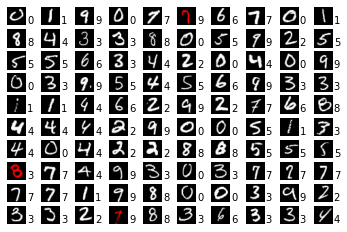

Loss for epoch 2 in iteration 0: 0.1222730502486229
Loss for epoch 2 in iteration 100: 0.18790550529956818
Loss for epoch 2 in iteration 200: 0.0966588705778122
Loss for epoch 2 in iteration 300: 0.11628749966621399
Loss for epoch 2 in iteration 400: 0.14382030069828033
Loss for epoch 2 in iteration 500: 0.06526597589254379
Loss for epoch 2 in iteration 600: 0.04281112179160118
Loss for epoch 2 in iteration 700: 0.021562127396464348
Loss for epoch 2 in iteration 800: 0.052459441125392914
Loss for epoch 2 in iteration 900: 0.06631001830101013

Test set: Average loss: 0.0911, Accuracy: 9745/10000 (97.45%)



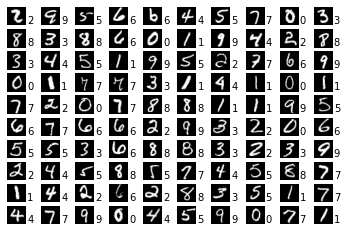

Loss for epoch 3 in iteration 0: 0.00528622604906559
Loss for epoch 3 in iteration 100: 0.03643358498811722
Loss for epoch 3 in iteration 200: 0.06603400409221649
Loss for epoch 3 in iteration 300: 0.06948499381542206
Loss for epoch 3 in iteration 400: 0.009289885871112347
Loss for epoch 3 in iteration 500: 0.10102367401123047
Loss for epoch 3 in iteration 600: 0.10945774614810944
Loss for epoch 3 in iteration 700: 0.2688501179218292
Loss for epoch 3 in iteration 800: 0.0018605994991958141
Loss for epoch 3 in iteration 900: 0.03828106075525284

Test set: Average loss: 0.0807, Accuracy: 9766/10000 (97.66%)



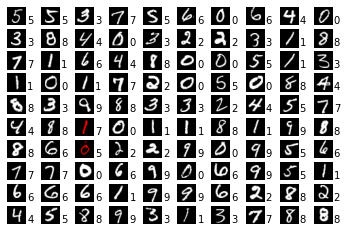

Loss for epoch 4 in iteration 0: 0.04334776848554611
Loss for epoch 4 in iteration 100: 0.013837562873959541
Loss for epoch 4 in iteration 200: 0.0030122040770947933
Loss for epoch 4 in iteration 300: 0.031333766877651215
Loss for epoch 4 in iteration 400: 0.045821525156497955
Loss for epoch 4 in iteration 500: 0.149317666888237
Loss for epoch 4 in iteration 600: 0.003602241398766637
Loss for epoch 4 in iteration 700: 0.009517676196992397
Loss for epoch 4 in iteration 800: 0.00015971761604305357
Loss for epoch 4 in iteration 900: 0.025137262418866158

Test set: Average loss: 0.0839, Accuracy: 9788/10000 (97.88%)



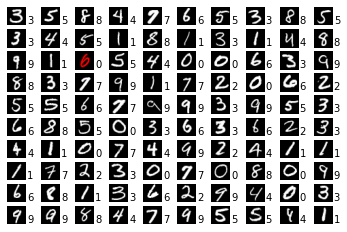

Loss for epoch 5 in iteration 0: 0.005915284156799316
Loss for epoch 5 in iteration 100: 0.0014111819909885526
Loss for epoch 5 in iteration 200: 0.08028848469257355
Loss for epoch 5 in iteration 300: 0.0006934314151294529
Loss for epoch 5 in iteration 400: 0.002485972596332431
Loss for epoch 5 in iteration 500: 0.017048629000782967
Loss for epoch 5 in iteration 600: 0.0007826169021427631
Loss for epoch 5 in iteration 700: 0.02602747268974781
Loss for epoch 5 in iteration 800: 0.001191808725707233
Loss for epoch 5 in iteration 900: 0.0343501903116703

Test set: Average loss: 0.0835, Accuracy: 9809/10000 (98.09%)



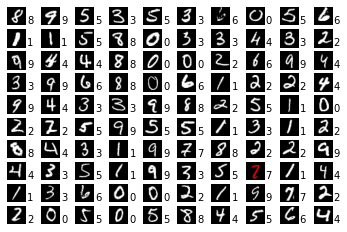

Loss for epoch 6 in iteration 0: 0.006664398591965437
Loss for epoch 6 in iteration 100: 0.0005637928261421621
Loss for epoch 6 in iteration 200: 0.0005254263523966074
Loss for epoch 6 in iteration 300: 0.056092120707035065
Loss for epoch 6 in iteration 400: 0.0024657349567860365
Loss for epoch 6 in iteration 500: 0.01214831043034792
Loss for epoch 6 in iteration 600: 0.06786554306745529
Loss for epoch 6 in iteration 700: 0.002104837214574218
Loss for epoch 6 in iteration 800: 0.00022337255359161645
Loss for epoch 6 in iteration 900: 0.00025403423933312297

Test set: Average loss: 0.0845, Accuracy: 9802/10000 (98.02%)



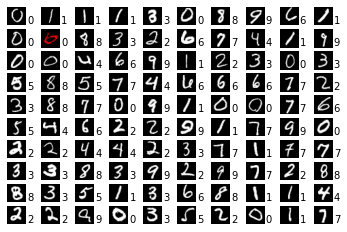

Loss for epoch 7 in iteration 0: 0.11115115880966187
Loss for epoch 7 in iteration 100: 0.1873338371515274
Loss for epoch 7 in iteration 200: 0.0018093178514391184
Loss for epoch 7 in iteration 300: 0.0021956416312605143
Loss for epoch 7 in iteration 400: 0.0008811799925751984
Loss for epoch 7 in iteration 500: 0.0038731831591576338
Loss for epoch 7 in iteration 600: 0.002721791621297598
Loss for epoch 7 in iteration 700: 0.0006059394218027592
Loss for epoch 7 in iteration 800: 0.0035178603138774633
Loss for epoch 7 in iteration 900: 0.024651845917105675

Test set: Average loss: 0.0883, Accuracy: 9807/10000 (98.07%)



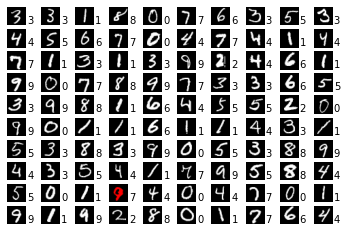

Loss for epoch 8 in iteration 0: 0.00034568976843729615
Loss for epoch 8 in iteration 100: 0.0010424075881019235
Loss for epoch 8 in iteration 200: 0.005798731464892626
Loss for epoch 8 in iteration 300: 0.00895980466157198
Loss for epoch 8 in iteration 400: 0.0012194907758384943
Loss for epoch 8 in iteration 500: 0.0027264996897429228
Loss for epoch 8 in iteration 600: 6.243193638511002e-05
Loss for epoch 8 in iteration 700: 0.000994920963421464
Loss for epoch 8 in iteration 800: 0.0004494985332712531
Loss for epoch 8 in iteration 900: 0.0008377779158763587

Test set: Average loss: 0.0900, Accuracy: 9817/10000 (98.17%)



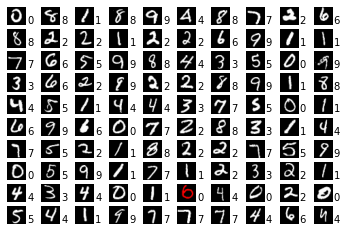

Loss for epoch 9 in iteration 0: 0.001220680307596922
Loss for epoch 9 in iteration 100: 0.0018053400563076138
Loss for epoch 9 in iteration 200: 0.0026416454929858446
Loss for epoch 9 in iteration 300: 0.000997894094325602
Loss for epoch 9 in iteration 400: 0.0008301562047563493
Loss for epoch 9 in iteration 500: 0.0008684483473189175
Loss for epoch 9 in iteration 600: 0.000478293834021315
Loss for epoch 9 in iteration 700: 0.00032919261138886213
Loss for epoch 9 in iteration 800: 0.0005429227603599429
Loss for epoch 9 in iteration 900: 0.0007134494371712208

Test set: Average loss: 0.0922, Accuracy: 9814/10000 (98.14%)



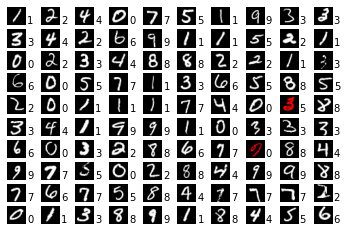

Loss for epoch 10 in iteration 0: 0.00047643089783377945
Loss for epoch 10 in iteration 100: 0.0014613756211474538
Loss for epoch 10 in iteration 200: 0.0004677418037317693
Loss for epoch 10 in iteration 300: 0.0025342791341245174
Loss for epoch 10 in iteration 400: 0.0037259645760059357
Loss for epoch 10 in iteration 500: 0.00021910072246100754
Loss for epoch 10 in iteration 600: 0.0007584133418276906
Loss for epoch 10 in iteration 700: 0.0007041766075417399
Loss for epoch 10 in iteration 800: 6.81480232742615e-05
Loss for epoch 10 in iteration 900: 0.0011636479757726192

Test set: Average loss: 0.0936, Accuracy: 9810/10000 (98.10%)



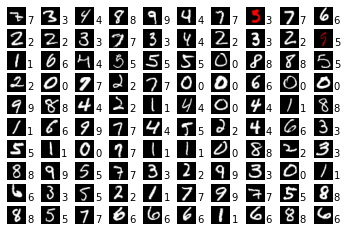

In [12]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)

    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()

    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")